In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math


In [2]:
torch.cuda.is_available()

True

In [3]:
from common import EEG_fif
from common import create_dataloader

In [4]:
# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = ''
base_url = 'https://physionet.org/files/eegmmidb/'
#runs = [4, 6, 8, 10, 12,14]
#runs = [3,5,7,9,11,13]
#runs = [3,4,5,6,7,8,9,10,11,12,13,14]

runs = [3,5,7,9]
#runs = [4,6,8,10]
#runs = [3,5,7,9,4,6,8,10]
subjects = [20]

print(path)
eeg = EEG_fif(path, base_url, subjects, runs)
raw=eeg.data_to_raw()

print("Raw done")
# apply filter
#freq = (1., 45.)

#raw=eeg.raw_ica(n_components=8,max_iter=1000)
raw=raw.notch_filter([50,75,100])
raw=raw.filter( 8,14, method='fir', verbose=20)


print("Filter done")

/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S020/S020R03.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S020/S020R05.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S020/S020R07.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fi

Raw done
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1651 samples (6.604 sec)



/home/nutapolt/eeg_mi/common.py:627: RuntimeWarning: This filename (S020/S020R09.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif( path_file , preload=True, verbose='WARNING' )
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Filtering raw data in 4 contiguous segments


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s finished


Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 413 samples (1.652 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s finished


Filter done


In [5]:
raw = raw.drop_channels(['Fp1', 'Fp2', 'P7', 'P8', 'O1', 'O2']
)
raw.ch_names

['C3', 'C4', 'STIM MARKERS']

Effective window size : 8.192 (s)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


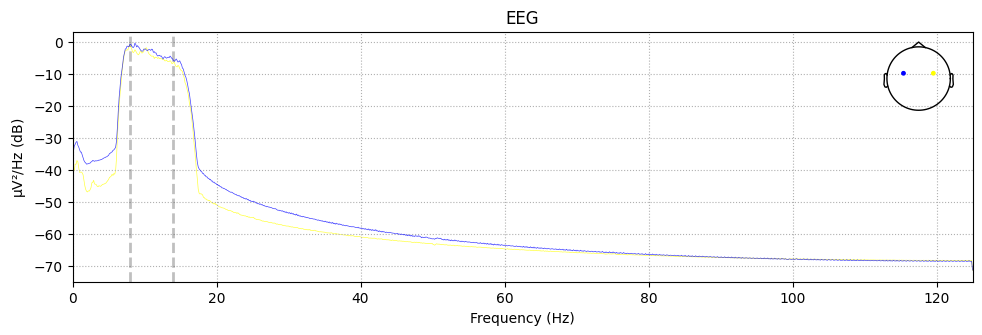

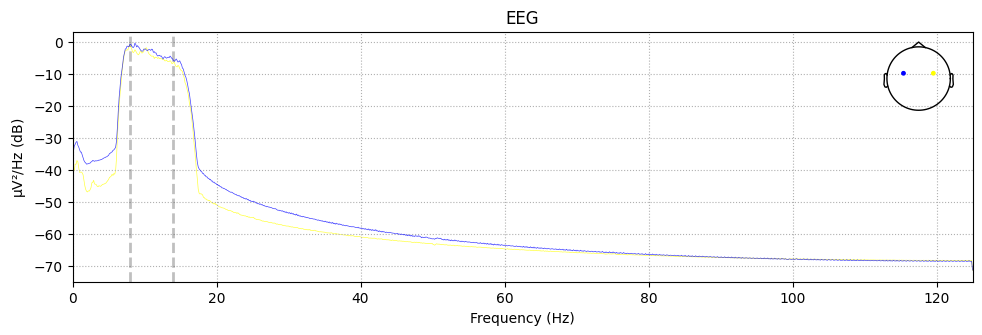

In [6]:
eeg.raw.plot_psd()

In [7]:
#epochs=eeg.epochs_visu(raw,tmin=0,tmax=6,baseline=(0,3))
epochs=eeg.epochs_visu(raw,tmin=0,tmax=7,baseline=(0,2))

360 events found
Event IDs: [1 2 4]
Not setting metadata
120 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 120 events and 1751 original time points ...
4 bad epochs dropped


/home/nutapolt/eeg_mi/common.py:657: RuntimeWarning: No matching events found for 3 (event id 3)
  epochs = mne.Epochs(


In [8]:
#X = X[:, :,np.newaxis,:]
X, y = eeg.get_X_y(epochs)
print(X.shape)
y=y-1
y

(116, 2, 1751)


array([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train size (81, 2, 1751) (81,)
Test size (35, 2, 1751) (35,)


In [10]:
y_test

array([1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0])

In [11]:

batch_size = 161

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

num_step =math.ceil(len(train_loader.dataset) / batch_size)

In [19]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        #using sequential helps bind multiple operations together
        self.layer1 = nn.Sequential(
            #padding = (kernel_size - 1) / 2 = 2
            nn.Conv1d(2, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv1d(128, 64, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        
        
        self.fc = nn.Linear(112064 , 2)
        self.drop_out = nn.Dropout(0.5)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = self.layer3(out)
        #out = self.drop_out(out)
        #out = self.layer4(out)
        #out = self.drop_out(out)

        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out

In [20]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [21]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [22]:

wand = wandb.init(
        
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"OurData_CNN_4layer_2ch_2class_S20_EX", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.0000001,
      "architecture": "CNN",
      "dataset": "S20",
      "epochs": 100000,
      "weightname":"OurData_CNN_4layer_2ch_2class_S20_EX",
      "num_step_per_epoch" : num_step, 
        
      }
    )



In [23]:
config = wand.config
print(config.num_step_per_epoch)

1


In [24]:
from common import train

In [ ]:
net = ConvNet().cuda(0)
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()


train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    gpu_num = 0,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    wand = wand
         )


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )

Epoch 1/100000, Tr Loss: 0.7253, Tr Acc: 55.5556, Val Loss: 0.6931, Val Acc: 51.4286
Epoch 101/100000, Tr Loss: 0.7194, Tr Acc: 45.6790, Val Loss: 0.7091, Val Acc: 51.4286
Epoch 201/100000, Tr Loss: 0.7134, Tr Acc: 45.6790, Val Loss: 0.6952, Val Acc: 51.4286
Epoch 301/100000, Tr Loss: 0.7064, Tr Acc: 56.7901, Val Loss: 0.6904, Val Acc: 48.5714
Epoch 401/100000, Tr Loss: 0.6469, Tr Acc: 64.1975, Val Loss: 0.6845, Val Acc: 51.4286
Epoch 501/100000, Tr Loss: 0.6546, Tr Acc: 59.2593, Val Loss: 0.6889, Val Acc: 60.0000
Epoch 601/100000, Tr Loss: 0.6195, Tr Acc: 71.6049, Val Loss: 0.6920, Val Acc: 51.4286
Epoch 701/100000, Tr Loss: 0.6512, Tr Acc: 65.4321, Val Loss: 0.6857, Val Acc: 51.4286
Epoch 801/100000, Tr Loss: 0.6494, Tr Acc: 61.7284, Val Loss: 0.6788, Val Acc: 60.0000
Epoch 901/100000, Tr Loss: 0.5744, Tr Acc: 70.3704, Val Loss: 0.6740, Val Acc: 57.1429
Epoch 1001/100000, Tr Loss: 0.6181, Tr Acc: 66.6667, Val Loss: 0.6790, Val Acc: 54.2857
Epoch 1101/100000, Tr Loss: 0.6035, Tr Acc: 

### GAMENET

In [ ]:
class gamenet(nn.Module):
    def __init__(self):
     
        super(gamenet,self).__init__()
        
        self.l1 = nn.Sequential(
            #in_channel = 16
            #out_channel or Filter size = 100
            #kernel size = (1,25)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(2,100,kernel_size=(1,2),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l2 = nn.Sequential(
            #in_channel = 100
            #out_channel or Filter size = 100
            #kernel size = (16,1)
            #stride = 1
            #padding = Valid
            #Relu
            nn.Conv2d(100,100,kernel_size=(1,2),stride=1,padding='valid'),
            #nn.Conv2d(100,100,kernel_size=(64,1),stride=1,padding='valid'),
            nn.ReLU(),
            nn.BatchNorm2d(100)
        )
        self.l3 = nn.Sequential(
            #in_channel = 100
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(100,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling1 = nn.MaxPool2d(kernel_size=(1,7),stride=5)
        self.l4 = nn.Sequential(
            #in_channel = 50
            #out_channel = 50
            #kernel size = (1,30)
            #stride = 1
            #padding = Same
            #Relu
            nn.Conv2d(50,50,kernel_size=(1,30),stride=1,padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(50)
        )
        self.maxpooling2 = nn.MaxPool2d(kernel_size=(1,3),stride=2)
        

        self.flatten = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(8700),
            nn.Dropout(0.15)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8700,1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.15)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(512,256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.15)
        )
        self.fc4 = nn.Sequential(
            nn.Linear(256,128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.15)
        )
        self.fc5 = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.15)
        )
        self.fc6 = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(0.15)
        )
        self.softmax = nn.Sequential(
            nn.Linear(32,2),
            nn.Softmax()
        )
    def forward(self,x):
        
        out = self.l1(x)
        out = self.l2(out)
        out = self.l3(out)
        out = self.maxpooling1(out)
        out = self.l4(out)
        out = self.maxpooling2(out)
        
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out)
        out = self.fc6(out)
        out = self.softmax(out)
        return out

In [ ]:
#X = X[:, :,np.newaxis,:]
batch_size =161

X, y = eeg.get_X_y(epochs)

print(X.shape)
y=y-1
y
X = X[:,:,np.newaxis,:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print('train size',X_train.shape, y_train.shape)
print('Test size',X_test.shape, y_test.shape)

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size)

num_step =math.ceil(len(train_loader.dataset) / batch_size)

In [ ]:
import wandb
wandb.login()
wand = wandb.init(
        
      # Set the project where this run will be logged
      project="Motor-Imagery", 
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"OurData_gamenet_2ch_2class_EX_S20_all", 
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.00000001,
      "architecture": "gamenet",
      "dataset": "S20",
      "epochs": 1000000,
      "weightname":"OurData_gamenet_2ch_2class_EX_S20_all",
      "num_step_per_epoch" : num_step, 
        
      }
    )
config = wand.config
print(config.num_step_per_epoch)


In [ ]:
from common import train

In [ ]:
net = gamenet().cuda(0)
optimizer = optim.Adam(net.parameters(), lr=config.learning_rate)
criterion = nn.CrossEntropyLoss()


train_loss,valid_loss,train_accuracy,valid_accuracy =train(
    model = net,
    gpu_num = 0,
    train_loader = train_loader,
    test_loader = test_loader,
    optimizer = optimizer  ,
    criterion = criterion ,
    wand = wand
         )


wandb.alert(
            title='Finish',
            text=f'Finishing training',
        )